## IMPORTACIÓN DE LIBRERÍAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
import seaborn as sns
import missingno
import itertools
from scipy.stats import entropy
import pyhomogeneity as hg
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller, bds
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError, Mean

## CONFIGURACIÓN GRÁFICA INICIAL

In [2]:
plt.rcParams.update({
    'figure.figsize': (16, 9),
    'lines.linewidth': 2,
    'lines.color': 'royalblue',
    'axes.labelsize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.titleweight': 'bold',
    'grid.linestyle': '--'
})

## CARGA Y PREPROCESAMIENTO DE DATOS

In [ ]:
csv_path = 'Precipitacion.csv'
df = pd.read_csv(csv_path, skiprows = 1,encoding='iso-8859-1')


In [ ]:
# Crear copia del dataframe original para hacerle modificaciones
df_long = df.copy()

# Transformación a formato largo
df_long = df.melt(id_vars=['Años'],
                    var_name='Mes',
                    value_name='Precipitación')

# Mapeo de meses a números
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'] 
mes_to_num = {mes: i + 1 for i, mes in enumerate(meses)}
df_long['month'] = df_long['Mes'].map(mes_to_num)

In [ ]:
# Creación de serie temporal
    # Renombrando las columnas para que la funcion datatime las identifique
df_long.rename(columns={'Años': 'year'}, inplace=True)
    # Creando vector de tiempo
df_long['Tiempo'] = pd.to_datetime(df_long[['year', 'month']].assign(day=1))
    # Ordenar los datos por tiempo y establer un índice de tiempo 
df_long = df_long.sort_values('Tiempo').set_index('Tiempo')


"\n# Creación de serie temporal\n    # Renombrando las columnas para que la funcion datatime las identifique\ndf_long.rename(columns={'Años': 'year'}, inplace=True)\n    # Creando vector de tiempo\ndf_long['Tiempo'] = pd.to_datetime(df_long[['year', 'month']].assign(day=1))\n    # Ordenar los datos por tiempo y establer un índice de tiempo \ndf_long = df_long.sort_values('Tiempo').set_index('Tiempo')\n"

### Gráfico de la serie temporal original (datos faltantes)

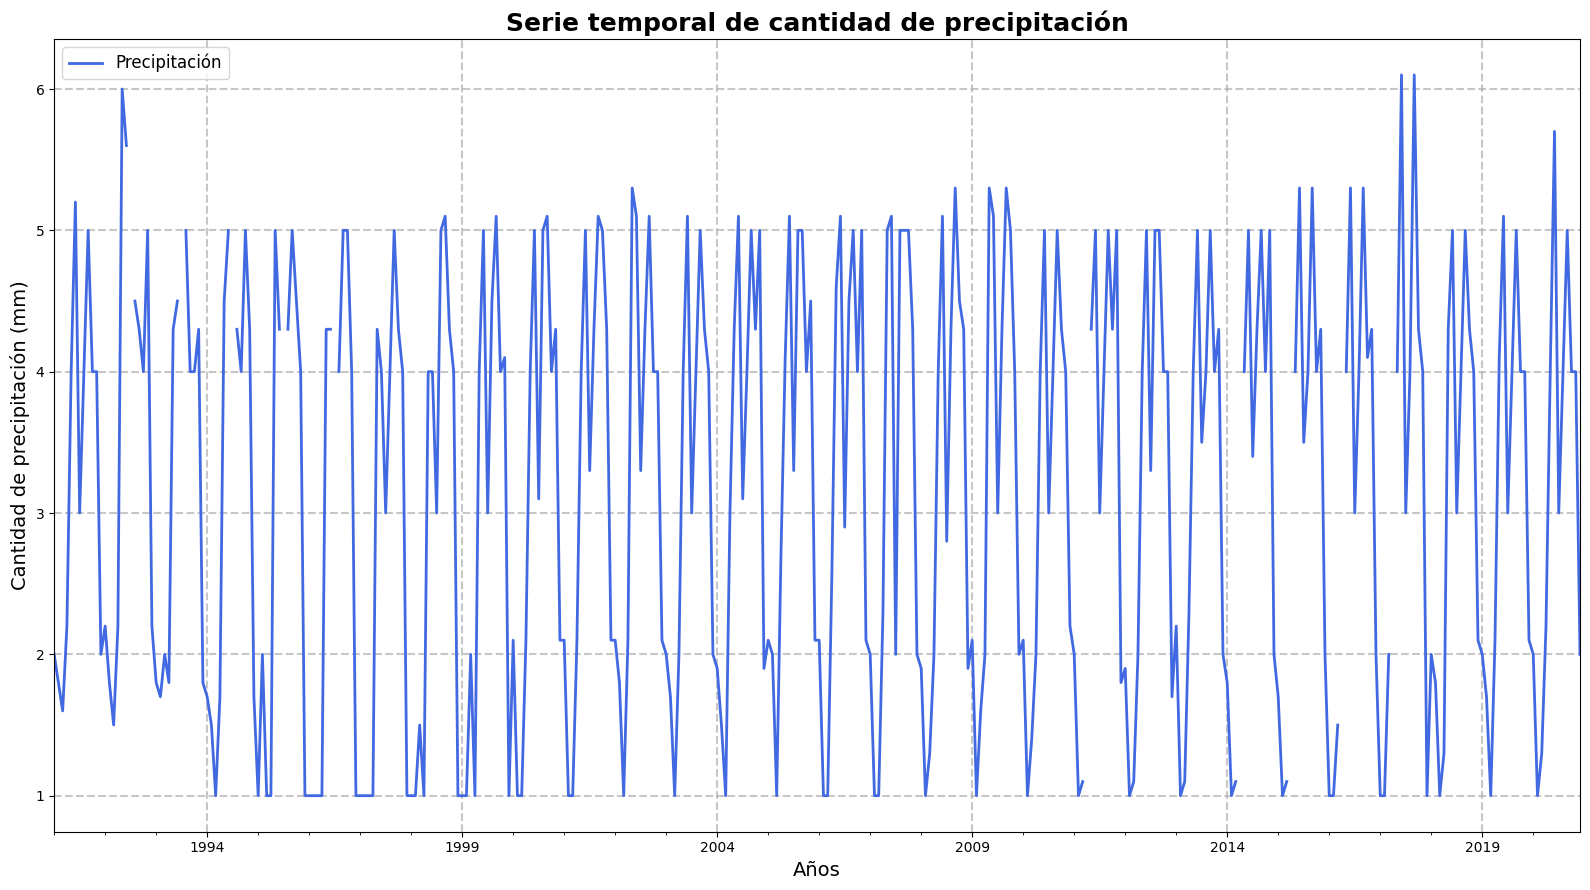

In [ ]:
df_long['Precipitación'].plot(label='Precipitación', color = 'royalblue')

# Personalización
plt.title('Serie temporal de cantidad de precipitación', fontsize=18)
plt.xlabel('Años')
plt.ylabel('Cantidad de precipitación (mm)')
plt.grid(linewidth=1.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout

In [7]:
# Copia para análisis de los datos originales
df_l_missing = df_long.copy()

## ANÁLISIS ESTADÍSTICO

### Medidas estadísticas

In [8]:
def medidas_estadisticas (df, columna='Precipitación'):

    # Calcular todas las medidas necesarias
    count = df[columna].count()
    v_min = df[columna].min()
    v_max = df[columna].max()
    mean = df[columna].mean()
    median = df[columna].median()
    std = df[columna].std()
    rango = v_max - v_min
    Q1 = df[columna].quantile(q=0.25)
    Q3 = df[columna].quantile(q=0.75)
    IQR = Q3 - Q1
    

    estadisticas = {
        'Medida estadística': [
            'Cantidad de valores',
            'Valor mínimo',
            'Valor máximo',
            'Media',
            'Mediana',
            'Desviación estándar',
            'Rango',
            'Cuartil 1 (Q1)',
            'Cuartil 3 (Q3)',
            'Rango intercuartil (IQR)'
        ],
        'Valor': [
            count,
            v_min,
            v_max,
            mean,
            median,
            std,
            rango,
            Q1,
            Q3,
            IQR
        ]
    }
    
    df_estadisticas = pd.DataFrame(estadisticas)
    
    return df_estadisticas

In [9]:
df_estadisticas = medidas_estadisticas(df_l_missing)
df_estadisticas

,Medida estadística,Valor
0,Cantidad de valores,350.000000
1,Valor mínimo,1.000000
2,Valor máximo,6.100000
3,Media,3.208000
4,Mediana,4.000000
5,Desviación estándar,1.502202
6,Rango,5.100000
7,Cuartil 1 (Q1),1.900000
8,Cuartil 3 (Q3),4.300000
9,Rango intercuartil (IQR),2.400000


### Visualización de distribución

#### Histograma

Text(0, 0.5, 'Cantidad')

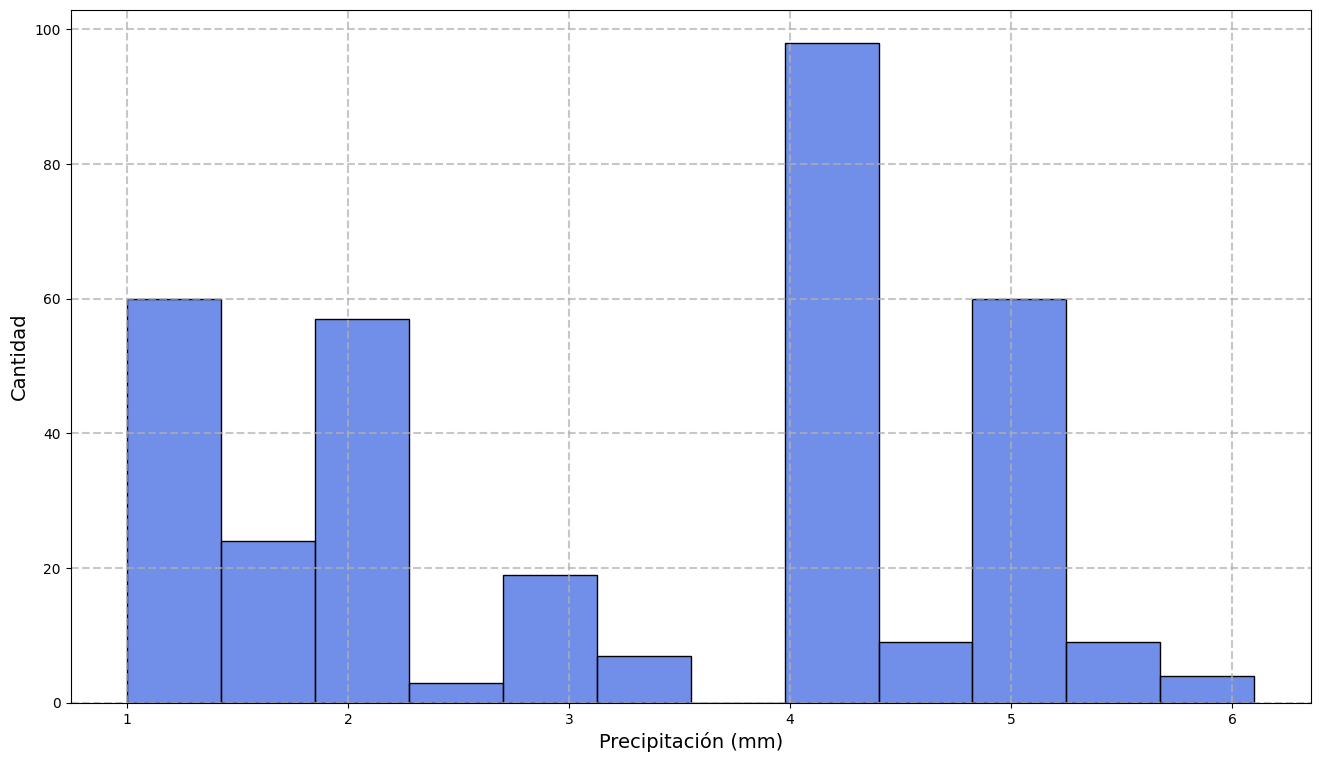

In [10]:
sns.histplot(df_l_missing, x = 'Precipitación', color='royalblue',bins=12)
plt.grid(linewidth=1.5, alpha=0.7)
plt.xlabel('Precipitación (mm)')
plt.ylabel('Cantidad')

#### Gráfico de densidad 

Text(0, 0.5, 'Densidad')

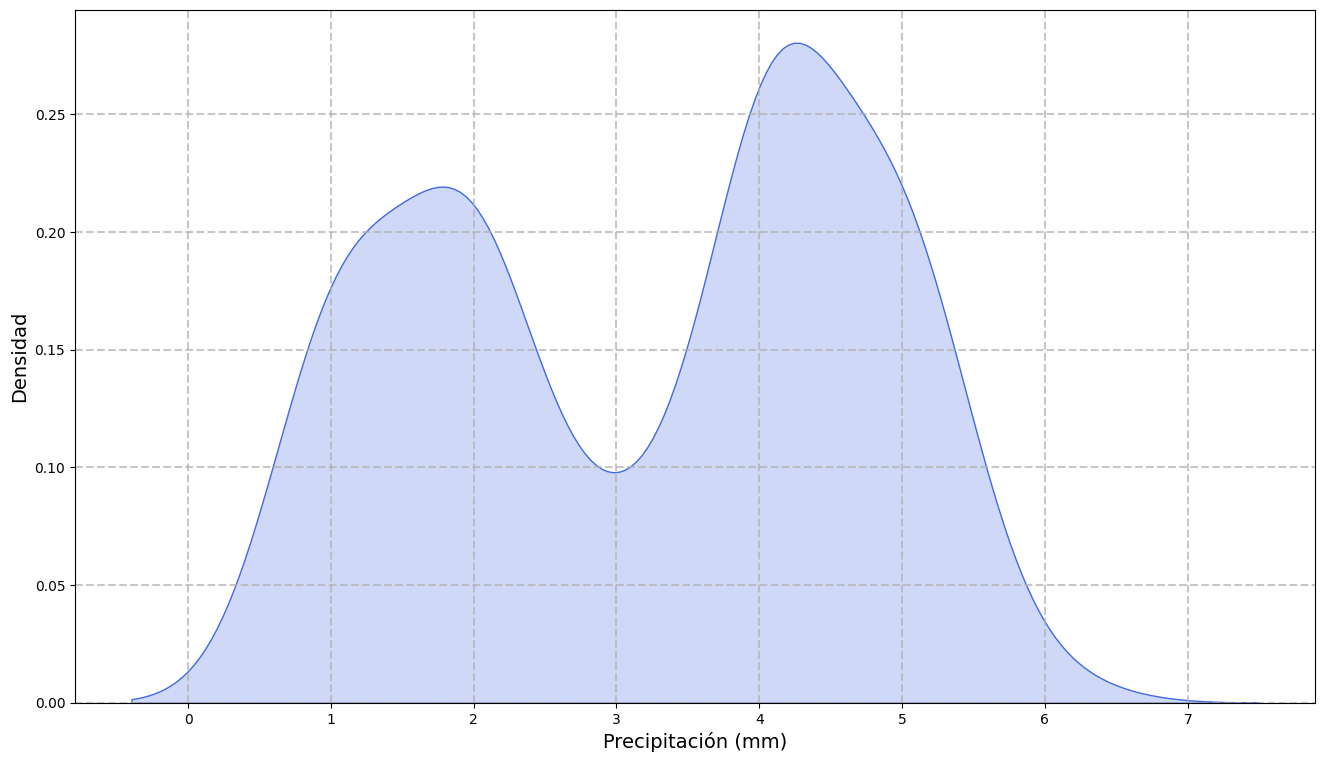

In [11]:
sns.kdeplot(df_l_missing, x = 'Precipitación', color='royalblue',fill = True, bw_adjust=1)
plt.grid(linewidth=1.5, alpha=0.7)
plt.xlabel('Precipitación (mm)')
plt.ylabel('Densidad')

#### Diagrama de caja

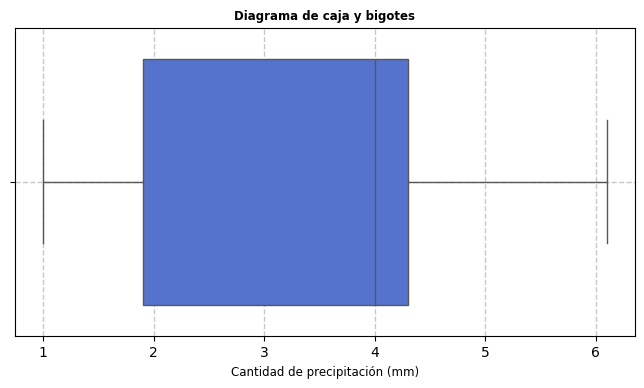

In [12]:
plt.figure(figsize=(8,4))
sns.boxplot(x = df_l_missing['Precipitación'], color = 'royalblue')
plt.grid(linewidth=1, alpha=0.7)
plt.title('Diagrama de caja y bigotes').set_fontsize(8.5)
plt.xlabel('Cantidad de precipitación (mm)').set_fontsize(8.5)

En el diagrama de caja observamos que: 
- La mediana se encuentra más cerca del cuartil 3 que del 1. 
- Los valores fuera del rango intercuartil no se consideran ouliers.
- La distribución se encuentra sesgada a la derecha.

De abril a mayo aumenta la cantidad de precipitación, diminuye de junio a julio, vuelve  aumentar de julio a agosto y disminuye finalmente de noviembre a diciembre. 

## ANÁLISIS DE DATOS FALTANTES

In [13]:
@pd.api.extensions.register_dataframe_accessor("missing")
class MissingMethods:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def number_missing(self) -> int:
        return self._obj.isna().sum().sum()

    def number_complete(self) -> int:
        return self._obj.size - self._obj.missing.number_missing()

    def missing_variable_summary(self) -> pd.DataFrame:
        return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_faltante")
                .rename(columns={"index": "variable"})
                .assign(
                    n_casos=len(df_1),
                    pct_faltante=lambda df_2: df_2.n_faltante / df_2.n_casos * 100,
                )
            )
        )

    def create_shadow_matrix(
        self,
        true_string: str = "Faltante",
        false_string: str = "No faltante",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return (
            self._obj
            .isna()
            .pipe(lambda df: df[df.columns[df.any()]] if only_missing else df)
            .replace({False: false_string, True: true_string})
            .add_suffix("_NA")
        )

    def bind_shadow_matrix(
        self,
        true_string: str = "Faltante",
        false_string: str = "No faltante",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return pd.concat(
            objs=[
                self._obj,
                self._obj.missing.create_shadow_matrix(
                    true_string=true_string,
                    false_string=false_string,
                    only_missing=only_missing
                )
            ],
            axis="columns"
        )

In [14]:
print(f"Datos completos: {df_l_missing.missing.number_complete()}")
print(f"Datos faltantes: {df_l_missing.missing.number_missing()}")
df_l_missing.missing.missing_variable_summary()

Datos completos: 1430
Datos faltantes: 10


,variable,n_faltante,n_casos,pct_faltante
0,year,0,360,0.000000
1,Mes,0,360,0.000000
2,Precipitación,10,360,2.777778
3,month,0,360,0.000000


### Matriz de sombra

In [15]:
shadow_matrix = (
    df_l_missing
    .missing
    .bind_shadow_matrix(only_missing=True)
)

In [16]:
# Agrupamos por 'weight_lbs_NA' y llamamos la columna 'age'
shadow_matrix.groupby(['Precipitación_NA'])['Mes'].describe().reset_index()

,Precipitación_NA,count,unique,top,freq
0,Faltante,10,2,Julio,5
1,No faltante,350,12,Enero,30


In [17]:
sm_faltante = shadow_matrix.copy()[shadow_matrix['Precipitación_NA']=='Faltante']

### Relación de valores faltantes con el mes

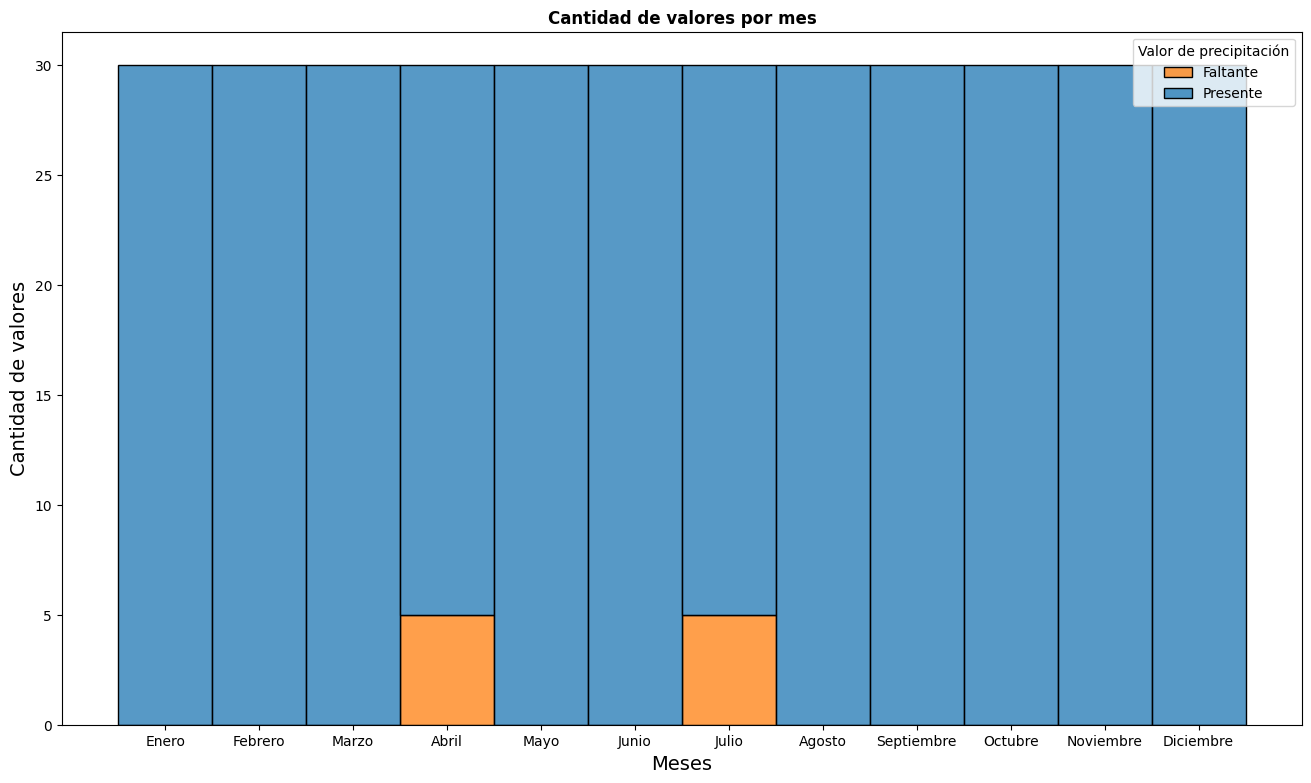

In [18]:
sns.histplot(shadow_matrix, x = 'Mes', hue='Precipitación_NA', multiple= 'stack', alpha = 0.75)
plt.title ('Cantidad de valores por mes')
plt.xlabel('Meses')
plt.ylabel('Cantidad de valores')
plt.legend(title = 'Valor de precipitación',labels = ('Faltante','Presente'))
plt.show()

Text(104.34722222222221, 0.5, 'Mes')

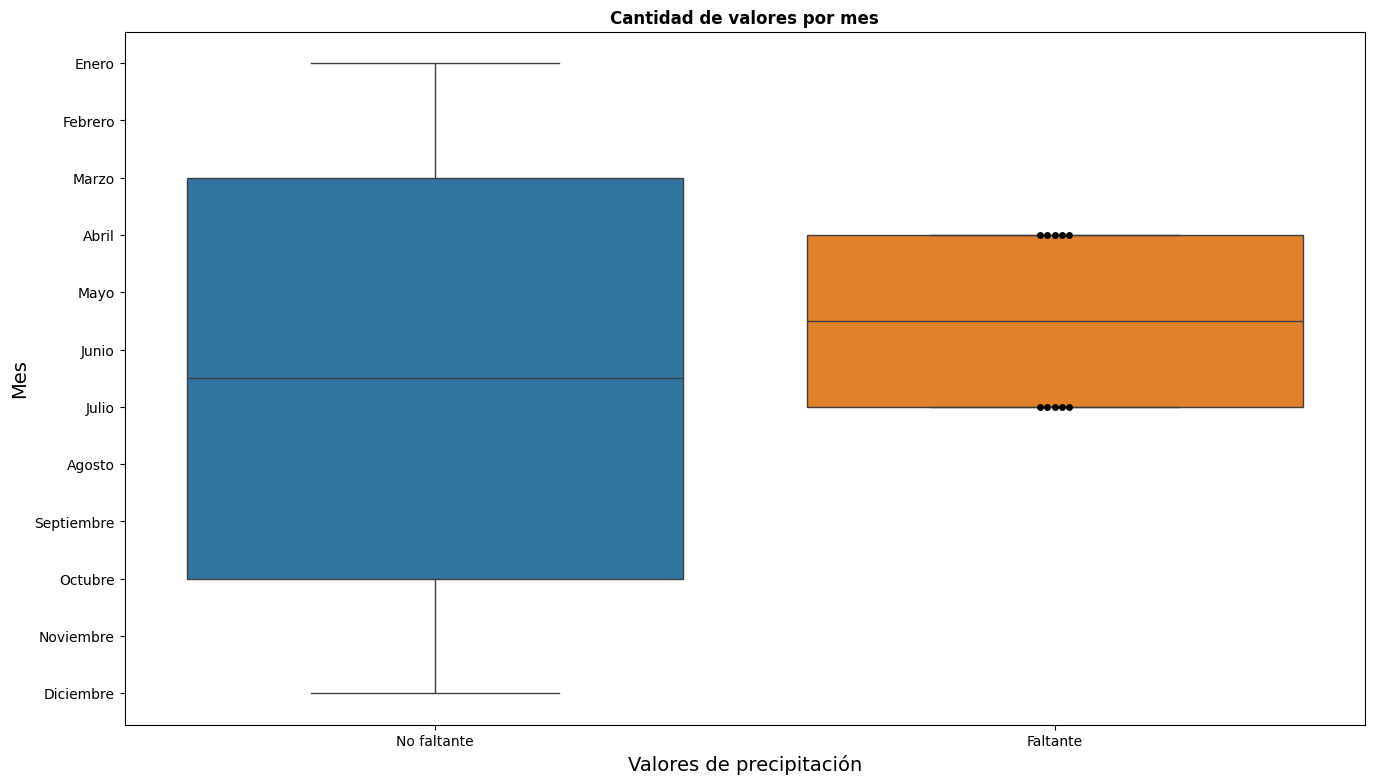

In [19]:
sns.boxplot(shadow_matrix, x = 'Precipitación_NA',y='Mes',hue='Precipitación_NA')
sns.swarmplot(sm_faltante, x = 'Precipitación_NA',y='Mes',color='black')
plt.title ('Cantidad de valores por mes')
plt.xlabel('Valores de precipitación')
plt.ylabel('Mes')

### Relación de valores faltantes con el año

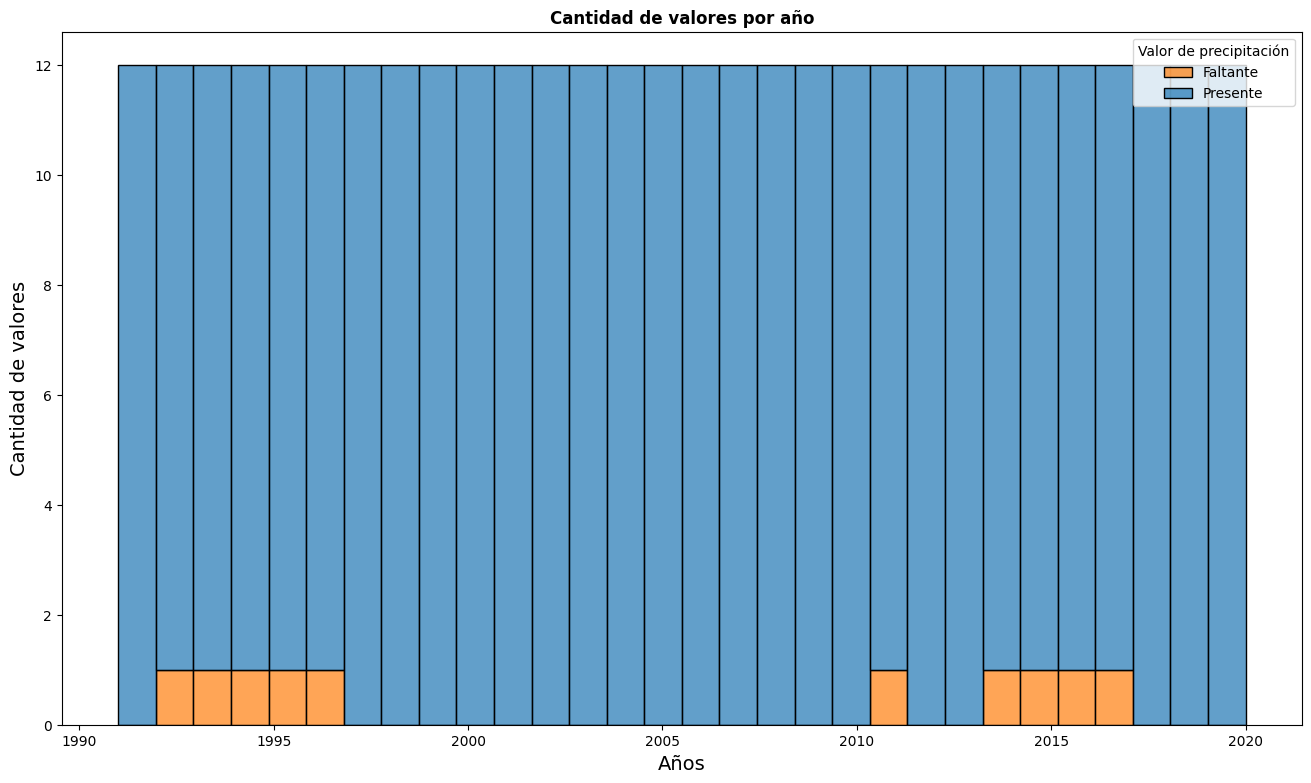

In [20]:
sns.histplot(shadow_matrix, x = 'year', hue='Precipitación_NA', multiple= 'stack', alpha = 0.70,bins=30)
plt.xlabel('Años')
plt.ylabel('Cantidad de valores')
plt.title ('Cantidad de valores por año')
plt.legend(title = 'Valor de precipitación',labels = ('Faltante','Presente'))

Text(149.34722222222223, 0.5, 'Años')

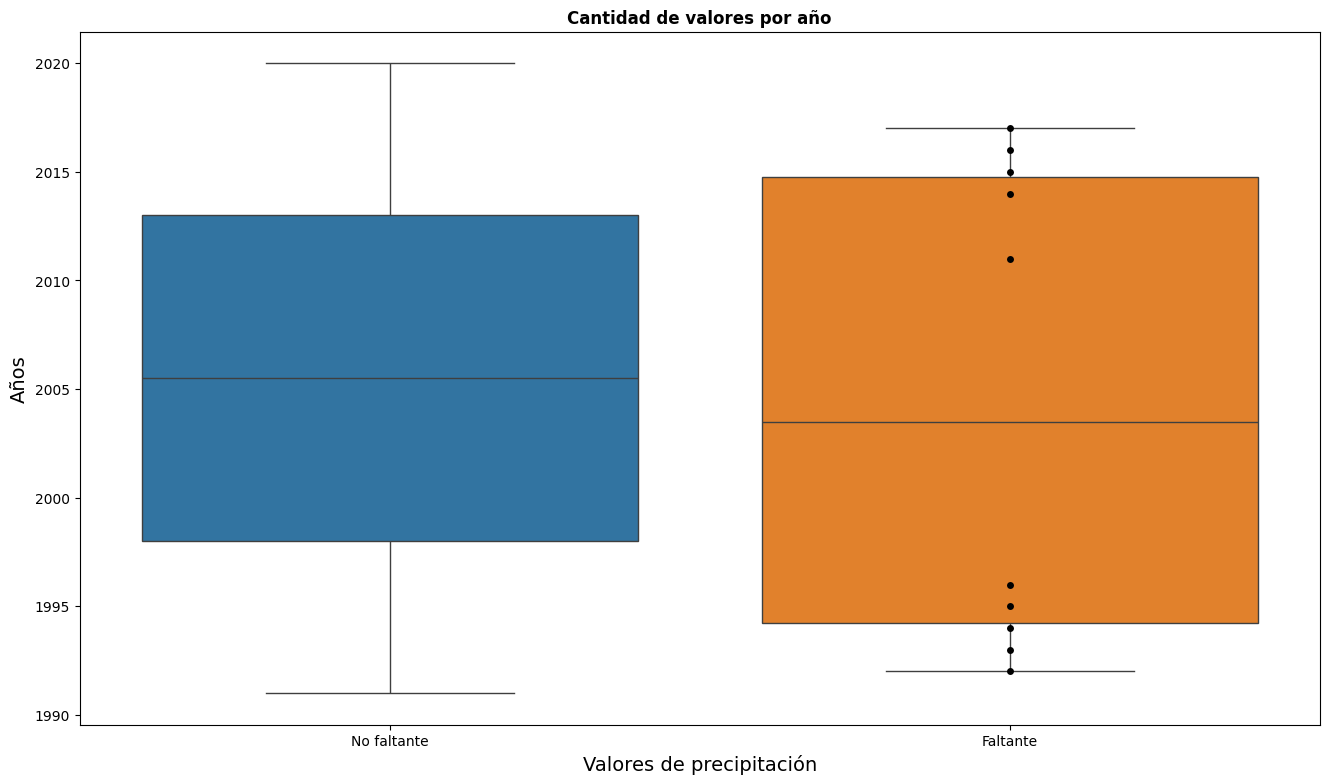

In [21]:
sns.boxplot(shadow_matrix, x = 'Precipitación_NA',y='year',hue='Precipitación_NA')
sns.swarmplot(sm_faltante, x = 'Precipitación_NA',y='year',color='black')
plt.title ('Cantidad de valores por año')
plt.xlabel('Valores de precipitación')
plt.ylabel('Años')


## IMPUTACIÓN DE VALORES FALTANTES

In [22]:
df_l_complete = df_l_missing.copy()

# Interpolación para valores faltantes
df_l_complete['Precipitación'] = df_l_complete['Precipitación'].interpolate(method='time')

### Gráfico de la serie temporal con datos interpolados

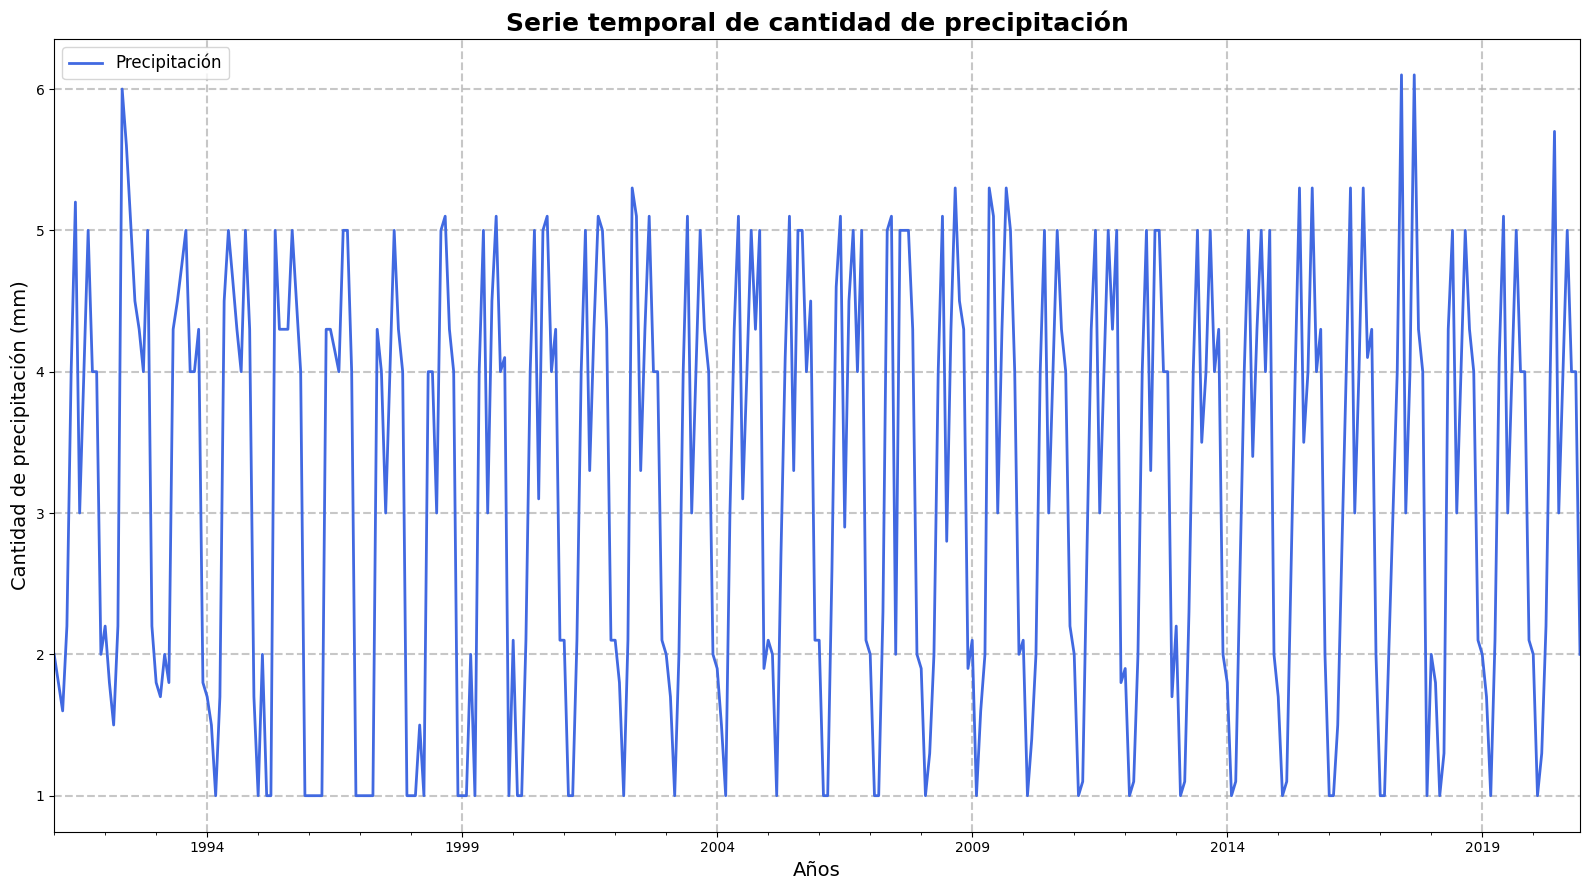

In [23]:
df_l_complete['Precipitación'].plot(label='Precipitación', color = 'royalblue')

plt.title('Serie temporal de cantidad de precipitación', fontsize=18)
plt.xlabel('Años')
plt.ylabel('Cantidad de precipitación (mm)')
plt.grid(linewidth=1.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

### Medidas estadísticas de la serie completa

In [24]:
stats_complete = medidas_estadisticas(df_l_complete)
stats_complete

,Medida estadística,Valor
0,Cantidad de valores,360.000000
1,Valor mínimo,1.000000
2,Valor máximo,6.100000
3,Media,3.220483
4,Mediana,4.000000
5,Desviación estándar,1.491609
6,Rango,5.100000
7,Cuartil 1 (Q1),2.000000
8,Cuartil 3 (Q3),4.300000
9,Rango intercuartil (IQR),2.300000


## CARACTERIZACIÓN DE LA SERIE TEMPORAL

### Tendencia y nivel

In [25]:
mk_result = mk.original_test(df_l_missing['Precipitación'],alpha=0.01)
print (mk_result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.5547046807938592, z=0.590725020230801, Tau=0.02103970528039296, s=1285.0, var_s=4724537.666666667, slope=0.0, intercept=4.0)


In [26]:
# Resultado del test Mann-Kendall
trend = mk_result.trend
slope = mk_result.slope
intercept = mk_result.intercept

# Calcular la línea de tendencia
trend_line = slope * np.arange(len(df_l_missing)) + intercept
nivel = np.full(len(df_l_missing), df_l_missing['Precipitación'].mean())

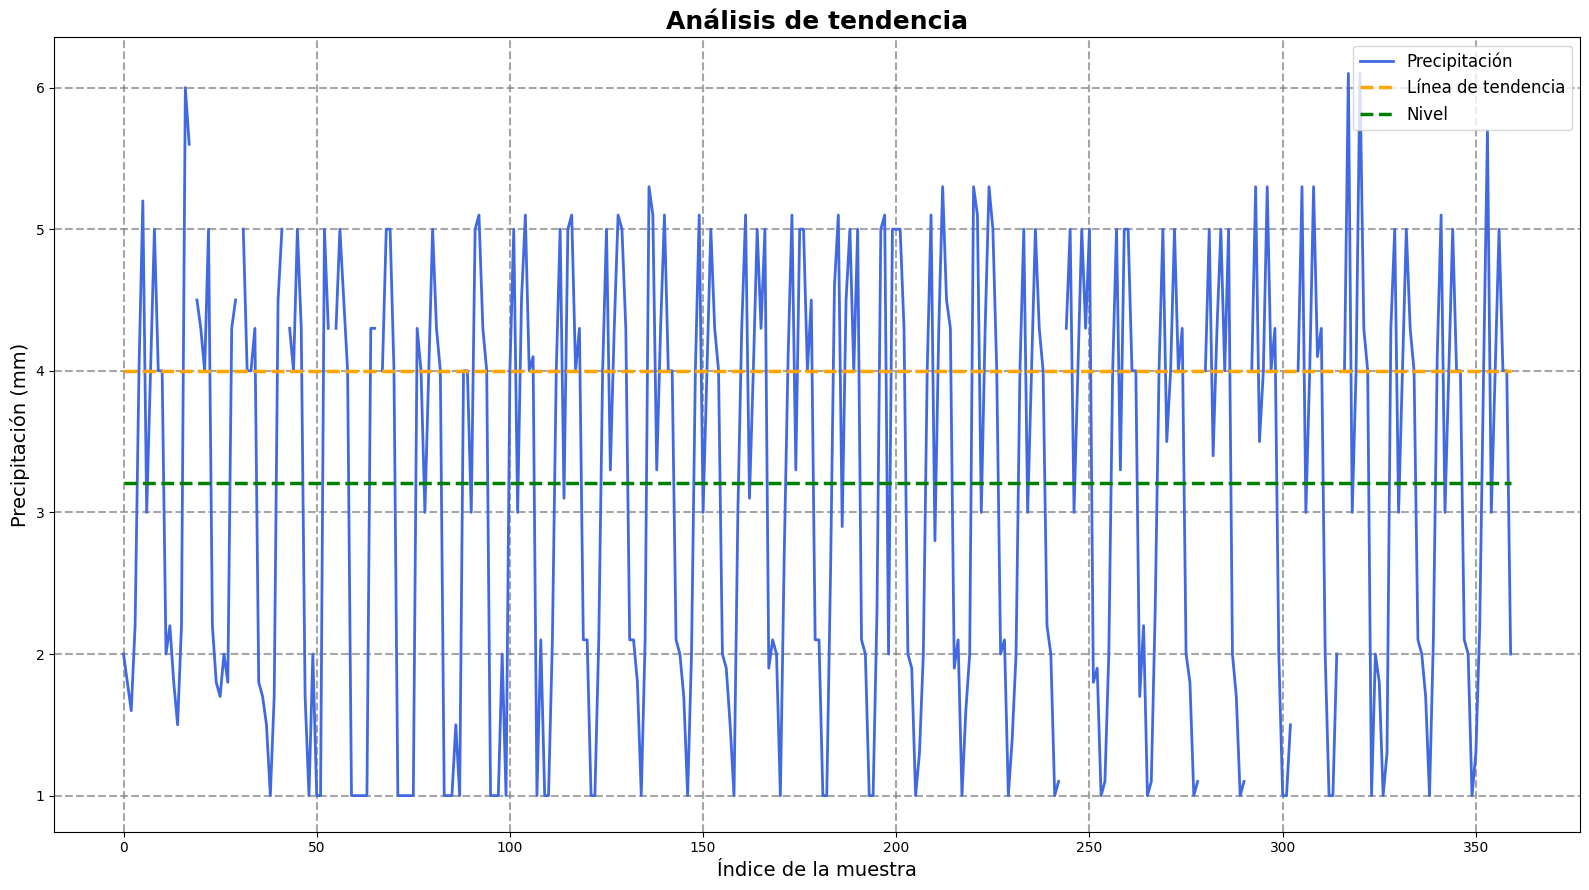

In [27]:
plt.plot (np.arange(len(df_l_missing ['Precipitación'])),df_l_missing['Precipitación'],label='Precipitación', color='royalblue')
plt.plot(np.arange(len(df_l_missing ['Precipitación'])), trend_line, label='Línea de tendencia', color='orange', linestyle='--', lw=2.5)  # Usar mismo eje x que trend_line
plt.plot(np.arange(len(df_l_missing ['Precipitación'])), nivel, label='Nivel', color='green', linestyle='--', lw=2.5)  # Usar mismo eje x

plt.title('Análisis de tendencia', fontsize=18)
plt.xlabel('Índice de la muestra', fontsize=14)  # Cambiado a "Índice"
plt.ylabel('Precipitación (mm)', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()

**Interpretación General**:
El test muestra que no hay una tendencia significativa en los datos (`no trend`), el valor p es alto, y la pendiente es `0.0`, lo que confirma que los valores no están aumentando ni disminuyendo de manera significativa a lo largo del tiempo. Esto indica estabilidad o ausencia de un patrón direccional en la serie temporal analizada.

### Estacionalidad

In [28]:
# Calcular el valor promedio de Precipitación mensual
mediana_mensual = df_l_missing.groupby('month')['Precipitación'].median()

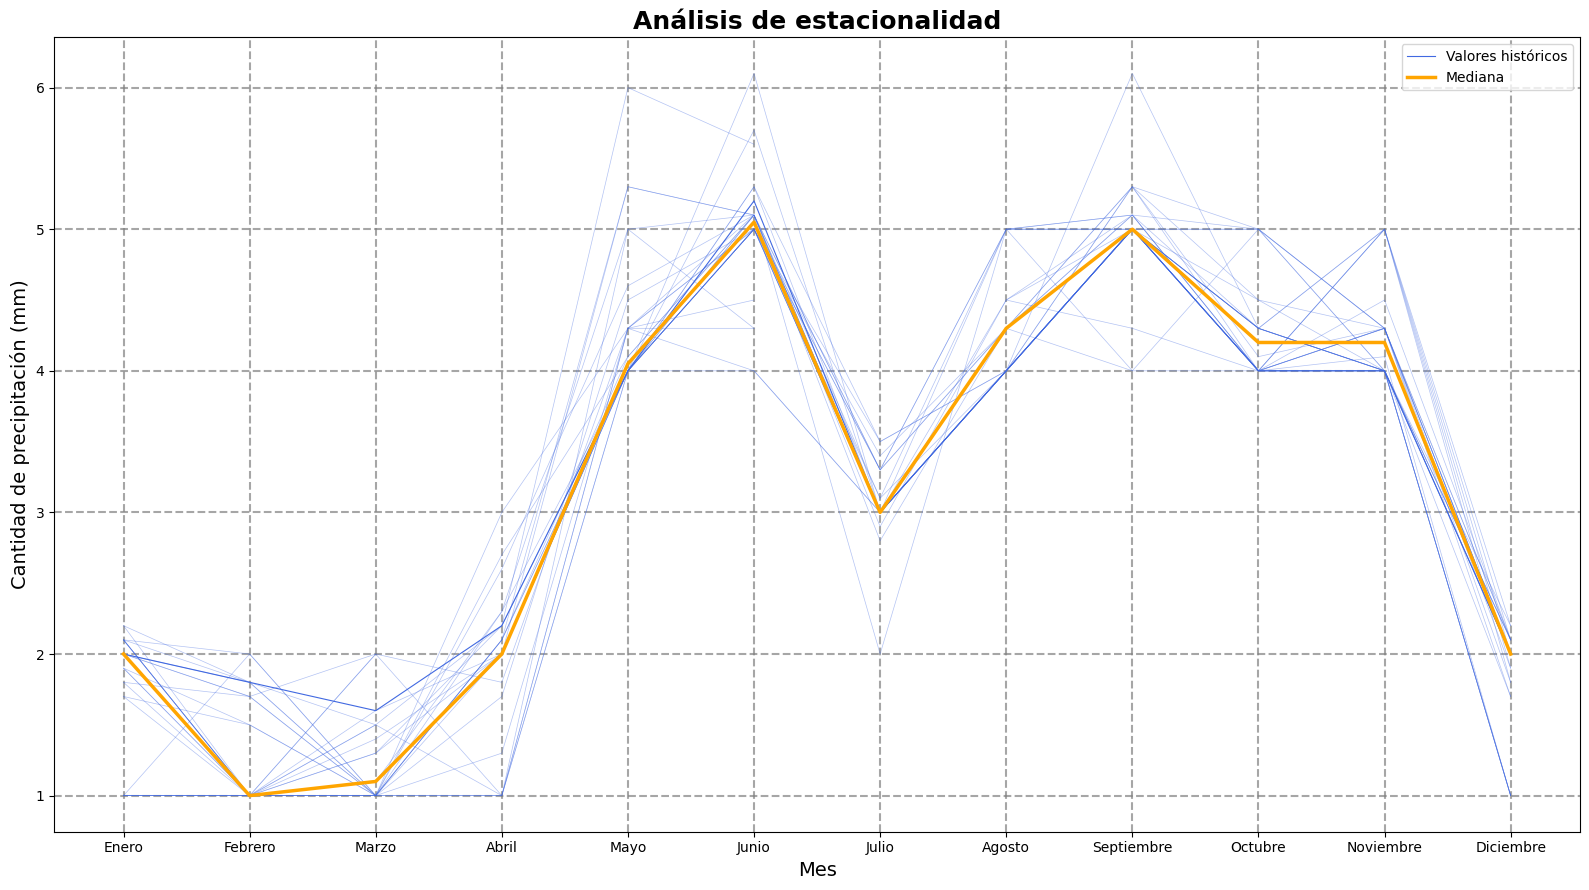

In [29]:
años = df_l_missing['year'].unique()

# Primer año
primer_año = df_l_missing[df_l_missing['year'] == años[0]]['Precipitación'].values
plt.plot(meses, primer_año, '-', color='royalblue', linewidth=0.8, label='Valores históricos')

# Años siguientes (1992 en adelante)
for año in años[1:]:
    datos_año = df_l_missing[df_l_missing['year'] == año]['Precipitación'].values
    plt.plot(meses, datos_año, '-', color='royalblue', linewidth=0.5, alpha=0.4)

plt.plot(meses, mediana_mensual, color='orange', linewidth=2.5, label='Mediana')

plt.title('Análisis de estacionalidad', fontsize=18)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Cantidad de precipitación (mm)', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.tight_layout()
plt.legend()

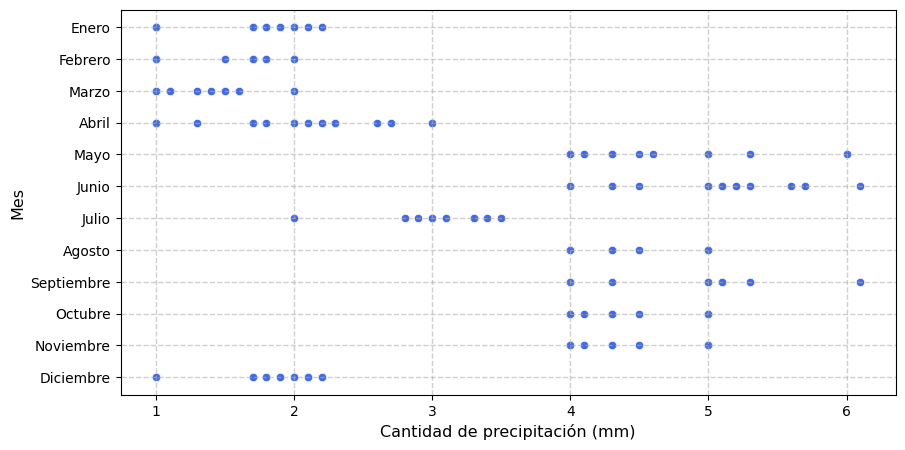

In [30]:
plt.figure(figsize=(10,5))
sns.scatterplot(data = df_l_missing, x = 'Precipitación', y='Mes', color = 'royalblue')
plt.xlabel ('Cantidad de precipitación (mm)').set_fontsize(11.5)
plt.ylabel ('Mes').set_fontsize(11.5)
plt.grid(linewidth=1, alpha=0.6)

### Estacionariedad 

In [31]:
def adf_test (timeseries):
    print ('Results of the Dickey-Fuller Test:')
    dftest = adfuller (timeseries, autolag='AIC')
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            'Test Statistic',
            'p-value',
            'Lags Number',
            'Number of Observation Used'
        ]
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print (dfoutput)
    
    # Interpretación
    if dftest[1] < 0.01:
        print("Rechazamos la hipótesis nula: la serie es estacionaria.")
    else:
        print("No se rechaza la hipótesis nula: la serie tiene una raíz unitaria y es no estacionaria.")

In [32]:
adf_test(df_l_complete['Precipitación'])

Results of the Dickey-Fuller Test:
Test Statistic                 -2.368781
p-value                         0.150742
Lags Number                    11.000000
Number of Observation Used    348.000000
Critical Value (1%)            -3.449282
Critical Value (5%)            -2.869881
Critical Value (10%)           -2.571214
dtype: float64
No se rechaza la hipótesis nula: la serie tiene una raíz unitaria y es no estacionaria.


**Interpretación general**: No se rechaza la hipótesis nula de que la serie tiene una raíz unitaria, es decir, no hay suficiente evidencia para afirmar que la serie es estacionaria.

## ANÁLISIS DE LA SERIE TEMPORAL

### Periodicidad

In [33]:
def comprobar_periodicidad(df, muestra):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)  

    # Calcular la fecha esperada para el siguiente mes
    df['Tiempo_siguiente_mes'] = df.index + pd.offsets.MonthBegin(1)

    # Calcular la diferencia excluyendo la última muestra
    df['Diferencia'] = df['Tiempo_siguiente_mes'].shift(1) - df.index

    # Filtrar diferencias no nulas (excluyendo el primer valor que es NaN por el shift)
    inconsistencias = df[df['Diferencia'] != pd.Timedelta(0)].dropna(subset=['Diferencia'])

    if inconsistencias.empty:
        print("Todas las muestras de precipitación se han tomado en intervalos de 1 mes.")
    else:
        print("Hay intervalos de tiempo inconsistentes en las muestras de precipitación.")
        print("Inconsistencias encontradas:")
        print(inconsistencias[['Tiempo_siguiente_mes', 'Diferencia']])

In [34]:
comprobar_periodicidad(df_l_missing, 'Precipitación')

Todas las muestras de precipitación se han tomado en intervalos de 1 mes.


### Homogeneidad


In [35]:
result_snht = hg.snht_test(df_l_missing['Precipitación'])
print (result_snht)

SNHT_Test(h=False, cp='1991-04-01', p=0.8251, T=3.067683320299107, avg=mean(mu1=1.9000000000000001, mu2=3.2231213872832365))


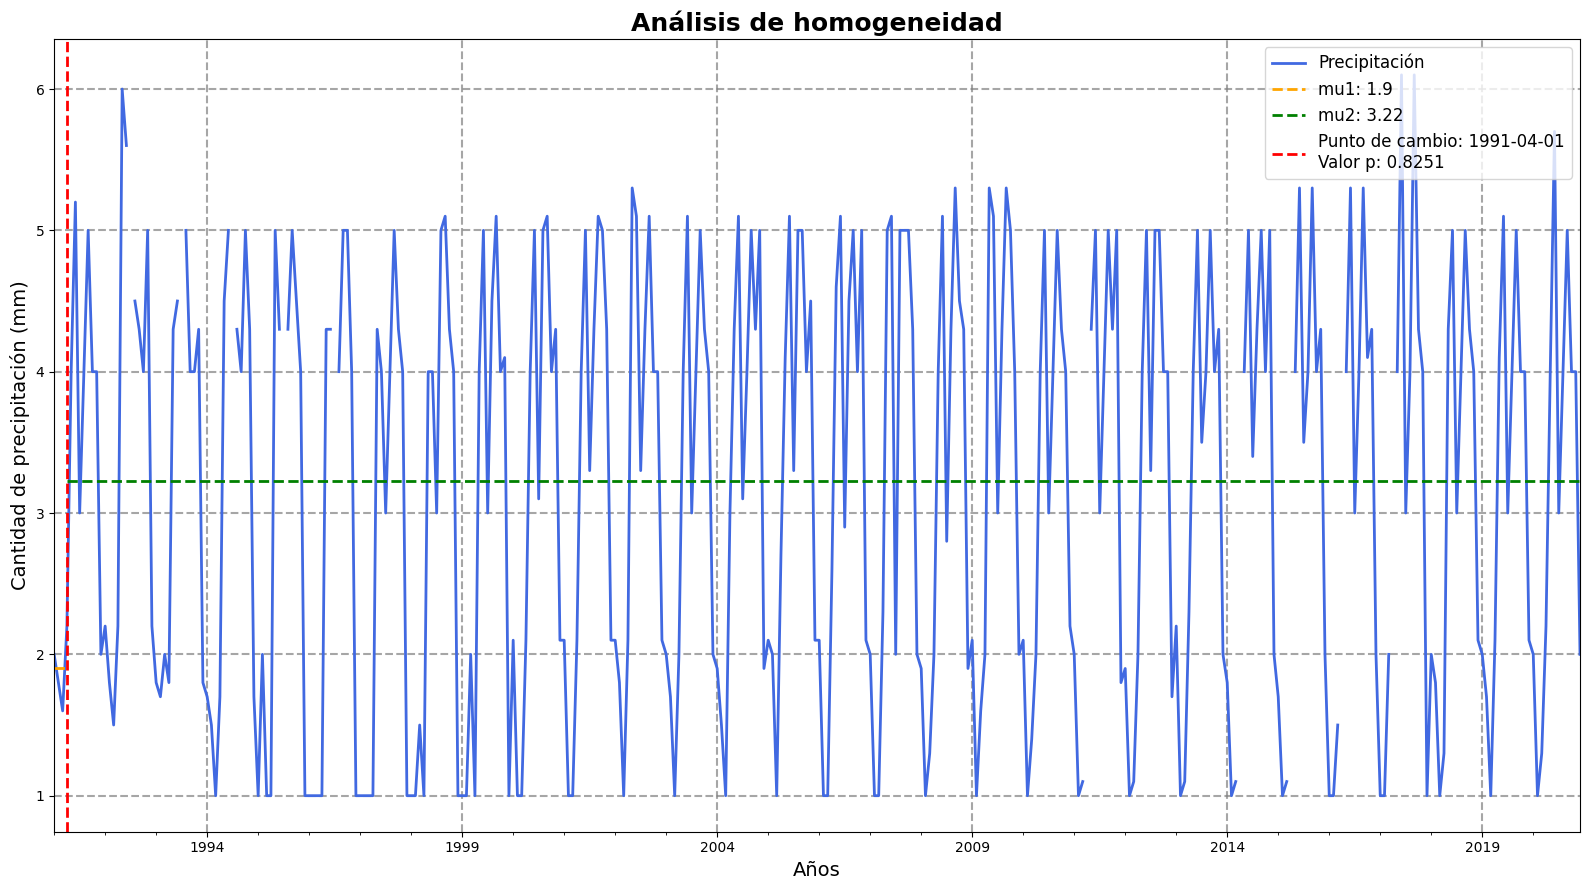

In [36]:
# Obtener estadísticos del test
loc = result_snht.cp         # Fecha del punto de cambio (ej: '1991-04-01')
mu1 = result_snht.avg.mu1    # Promedio antes del cambio
mu2 = result_snht.avg.mu2    # Promedio después del cambio

# Graficar la serie de precipitación
df_l_missing['Precipitación'].plot(label='Precipitación', color='royalblue')

# Líneas horizontales (usando fechas)
plt.hlines(mu1, 
           xmin=df_l_missing.index.min(),  
           xmax=pd.to_datetime(loc),       
           linestyles='--', lw=2, colors='orange', 
           label=f'mu1: {round(mu1, 2)}')

plt.hlines(mu2, 
           xmin=pd.to_datetime(loc),       
           xmax=df_l_missing.index.max(),  
           linestyles='--', colors='g', lw=2, 
           label=f'mu2: {round(mu2, 2)}')

# Línea vertical del punto de cambio 
plt.axvline(x=pd.to_datetime(loc), 
            linestyle='--', color='red', lw=2,
            label=f'Punto de cambio: {loc}\nValor p: {result_snht.p}')

plt.title('Análisis de homogeneidad', fontsize = 18)
plt.xlabel('Años')
plt.ylabel('Cantidad de precipitación (mm)')
plt.legend(loc='upper right',fontsize = 12)
plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.tight_layout()

**Interpretación General:**

Dado que no se detectó un cambio estadísticamente significativo en la serie temporal (con base en h=False y un valor p alto), se puede concluir que la serie es homogénea.

### No linealidad

In [37]:
def bds_test (timeseries, alpha):
    print ('Results of the BDS Test:')
    dftest = bds (timeseries)
    print (f'Test Statistic: {dftest[0]}')
    print (f'p-value: {dftest[1]}')
    if dftest[1] < alpha:               #se compara el p value con el nivel de significancia 
        print ('La serie es no lineal') 

bds_test(df_l_complete['Precipitación'], 0.01) #establecemos un nivel de significancia de 0.01



Results of the BDS Test:
Test Statistic: 29.095726815260896
p-value: 4.065787252981372e-186
La serie es no lineal


### Complejidad de la serie: autocorrelación

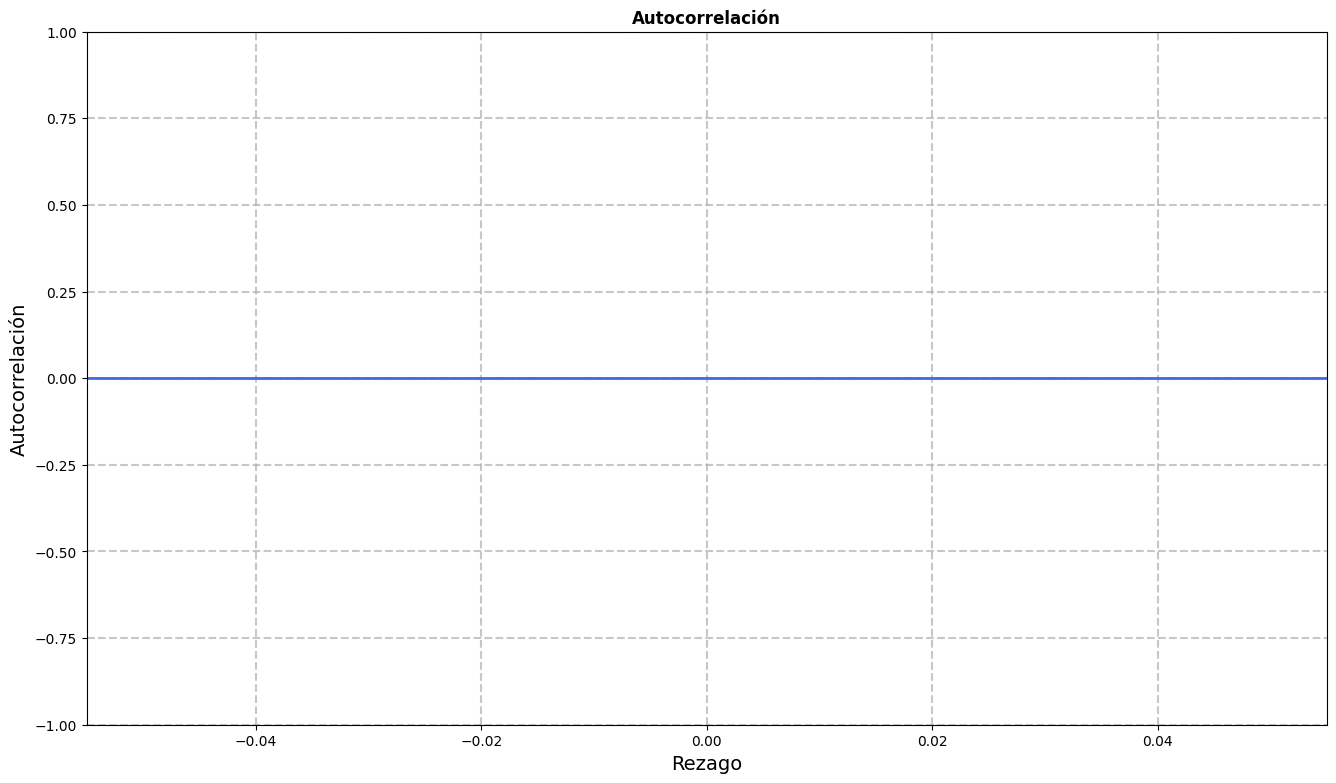

In [38]:
plot_acf(df_l_missing['Precipitación'],alpha=0.01,lags=1)
plt.title('Autocorrelación')
plt.xlabel ('Rezago')
plt.ylabel('Autocorrelación')
plt.grid(linewidth=1.5, alpha=0.7)
plt.show()

## MODELO RNA-LSTM

###  Preprocesamiento

#### Conjuntos de entrenamiento y prueba

In [39]:
data = df_l_complete ['Precipitación'].values.copy() #valores de precipitacion
indices = df_l_complete.reset_index().index.to_numpy() #se toman los índices correspondientes a las fechas

#Tamaño de los conjuntos
test_size = 48
Train_size = len(data)-test_size
val_size = 48 

data_test =  data[Train_size:] #precipitacion prueba
data_Train = data[:Train_size] #precipitacion entrenamiento

indices_test =  indices[Train_size:] #index del set de prueba
indices_Train = indices[:Train_size] #index del set de entrenamiento

#### Escalamiento de los datos: MinMaxScaler

In [40]:
data_test = data_test.reshape(-1,1)
data_Train = data_Train.reshape(-1,1)

# Ajustando el escalador con la data de entrenamiento
scaler_data = MinMaxScaler(feature_range=(-1,1))
scaler_data.fit(data_Train)

#Escalando los datos
data_Train_scaled = scaler_data.transform(data_Train)
data_test_scaled = scaler_data.transform(data_test)

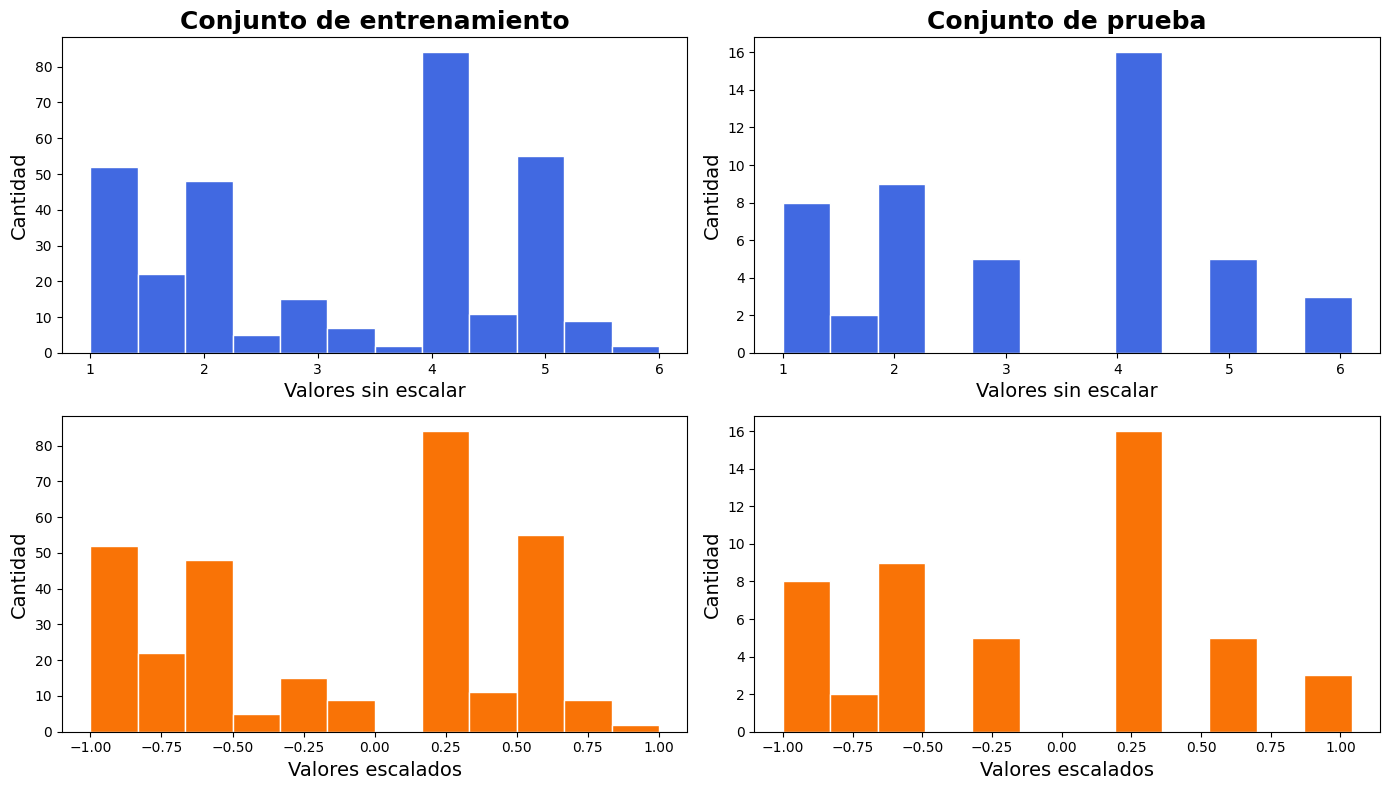

In [41]:
plt.figure(figsize=(14,8))
plt.subplot (2,2,1)
plt.hist(data_Train, bins=12, color = 'royalblue', edgecolor = 'white')
plt.title('Conjunto de entrenamiento', fontsize=18)
plt.xlabel('Valores sin escalar', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

plt.subplot (2,2,3)
plt.hist(data_Train_scaled, bins=12, color = '#F97306', edgecolor = 'white')
plt.xlabel('Valores escalados', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

plt.subplot (2,2,2)
plt.hist(data_test, bins=12, color = 'royalblue', edgecolor = 'white')
plt.title('Conjunto de prueba', fontsize=18)
plt.xlabel('Valores sin escalar', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

plt.subplot (2,2,4)
plt.hist(data_test_scaled, bins=12, color = '#F97306', edgecolor = 'white')
plt.xlabel('Valores escalados', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

plt.tight_layout()

### Contrucción del modelo

In [42]:
input_length = 24 
output_length = 12

inputs = Input(shape=(input_length,1))
input_layer_out = LSTM (24,return_sequences=True)(inputs)
lstm_out_1 = LSTM(24)(input_layer_out)
outputs = Dense(12)(lstm_out_1)

model = Model(inputs=inputs, outputs=outputs)
model.compile (optimizer=Adam (learning_rate=0.0005), loss="mae",metrics=[RootMeanSquaredError])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 24)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24)             │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,500 (29.30 KB)

 Trainable params: 7,500 (29.30 KB)

 Non-trainable params: 0 (0.00 B)

#### Generación de las secuencias de entrada

In [43]:
def Sequence_generator (array, input_length, output_length):
    y = []
    x = np.array(np.lib.stride_tricks.sliding_window_view(array[:(len(array)-output_length)],window_shape=input_length,axis=0))
    y = np.array(np.lib.stride_tricks.sliding_window_view(array[input_length:],window_shape=output_length,axis=0))
    return x,y

### Entrenamiento con protocolo de evaluación: TimeSeriesSlip 

In [ ]:
# Crear el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4, test_size=val_size)

# Listas para almacenamiento de las métricas
all_histories = []

# Aplicar TimeSeriesSplit
for train_index, val_index in tscv.split(indices_Train):
    indices_train, indices_val = indices[train_index], indices[val_index] #index
    data_train, data_val = data[train_index], data[val_index] #precipitacion

    
    x_strain, y_strain = Sequence_generator (data_train,input_length,output_length)
    x_sval, y_sval = Sequence_generator (data_val,input_length,output_length)
    
    history = model.fit(
        x_strain,
        y_strain,
        batch_size=36,
        epochs=500,
        validation_data=(x_sval, y_sval),
        verbose=0)
    
    # Almacenando las métricas
    all_histories.append(history)

### Comportamiento del protocolo en los datos

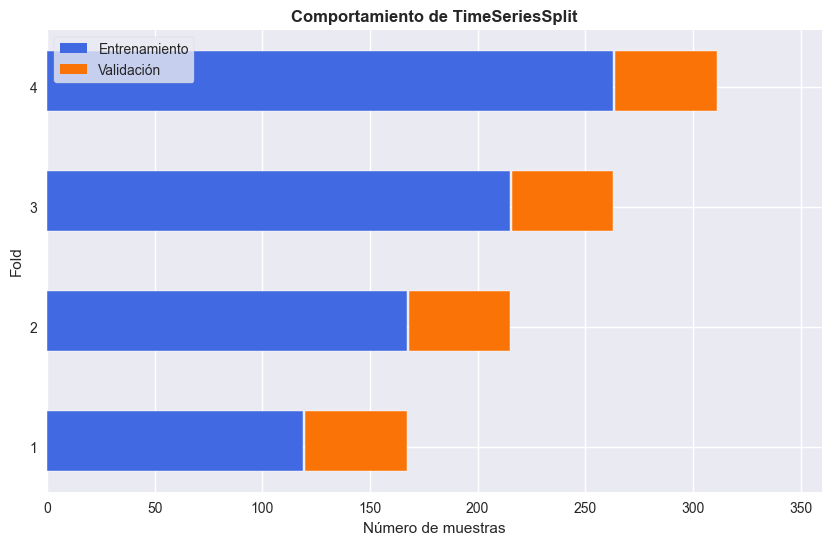

In [45]:
plt.style.use('seaborn-v0_8')
# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Plotear cada iteración de TimeSeriesSplit
for i, (train_idx, val_idx) in enumerate(tscv.split(data_Train)):
    ax.fill_between(train_idx, i+0.8, i + 1.3, color='royalblue', edgecolor="white", label="Train" if i == 0 else "")
    ax.fill_between(val_idx, i+0.8, i + 1.3, color='#F97306', edgecolor="white", label="Test" if i == 0 else "")
    #ax.text(-5, i + 1, f"Iter {i}", va='center', ha='right', fontsize=10)

# Etiquetas y título
ax.set_xlabel("Número de muestras")
ax.set_ylabel("Fold")
ax.set_title("Comportamiento de TimeSeriesSplit")
ax.yaxis.set_major_locator(MultipleLocator (1))

# Añadir leyenda
legend_elements = [
    Patch(facecolor='royalblue', label="Entrenamiento"),
    Patch(facecolor='#F97306', label="Validación")
]
ax.legend(handles=legend_elements, loc = 'upper left', frameon = True )

# Ajustar los límites y mostrar el gráfico
ax.set_xlim(0, 360)
plt.show()

### Visualización de la función de pérdida

In [55]:
def loss_fuction (histories, folds = False):
    # Extraer datos de perdida
    loss = []
    val_loss = []
    for history in histories: 
       loss.append(history.history['loss'])
       val_loss.append(history.history['val_loss'])
    
    epochs = len(loss[0]) #epocas por ciclo
    ciclos = len (loss) #total de folds
    
    # Valores Eje x 
    x_values = []
    extended_loss = []
    extended_val_loss = []
    
    for ciclo in range (ciclos):
        x_cycle = np.arange(epochs) + (ciclo * epochs)
        x_values.extend(x_cycle)
    
    if folds == True:
        for i, history in enumerate (histories):
            fig, ax = plt.subplots(figsize=(18, 6))
            ax.plot (history.history['loss'], "#3458BB", label = 'Pérdida de entrenamiento')
            ax.plot (history.history['val_loss'], "#F21216", label = 'Pérdida de validación')

            ax.set_xticks(range(0,epochs))
            ax.set_xticklabels([str(epochs+1) for epochs in range(0,epochs) ])
            ax.set_xticks([0]+ [i for i in range(int((epochs/10)-1),epochs+1,int(epochs/10))])

            plt.title (f'Función de pérdida en el fold {i+1}', pad = 15, fontsize = 14)
            plt.xlabel ('Épocas', fontsize = 12)
            plt.ylabel ('Valor de la pérdida', fontsize = 12)
            ax.yaxis.set_major_locator(MultipleLocator (0.025))
            ax.legend(loc = 'upper right', frameon = True )
            plt.grid (True, linestyle = '--', alpha = 1)

    else:
        extended_loss = np.array(loss).flatten()
        extended_val_loss = np.array(val_loss).flatten()

        # Graficar
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot (x_values, extended_loss, "#3458BB", label = 'Pérdida de entrenamiento', alpha = 1, linewidth=1)
        ax.plot (x_values, extended_val_loss, "#F21216", label = 'Pérdida de validación', alpha = 1,linewidth=1)

        #Conf eje x
        ax.set_xticks(x_values)
        ax.set_xticklabels([str((i % epochs)+1) for i in x_values])
        ax.set_xticks([0]+[((epochs*i)/2)-1 for i in range (1,((ciclos*2)+1))])

        #Divisiones
        for ciclo in range (1,ciclo + 1):
            ax.axvline(x=ciclo*epochs,color = 'gray', linestyle = '--', linewidth = 1, alpha = 0.7)
        
        for ciclo in range (ciclo+1):
            ax.text(ciclo*epochs + (epochs/2)-(epochs/12),(max(max(extended_loss),max(extended_val_loss))-0.2),f'Fold {ciclo+1}',fontsize = 12,alpha = 0.5)

        plt.title ('Función de pérdida', pad = 15, fontsize = 14)
        plt.xlabel ('Épocas', fontsize = 12)
        plt.ylabel ('Valor de la pérdida', fontsize = 12)
        ax.yaxis.set_major_locator(MultipleLocator (0.3))
        ax.legend(loc = 'best', frameon = True )
        plt.grid (True, linestyle = '--', alpha = 1)

In [1]:
loss_fuction(all_histories,folds=False)

NameError: name 'loss_fuction' is not defined

### Predicción

In [48]:
x_stest, y_stest = Sequence_generator (data_test,input_length,output_length)
x_stest = x_stest.reshape(13,24)
y_stest = y_stest.reshape(13,12)

y_pred = model.predict(x_stest,verbose=0)

predicción = y_pred[len(y_pred)-1]
real = y_stest[len(y_pred)-1]

### Evaluación del modelo

In [49]:
#Evaluando el modelo
test_history = model.evaluate(x_stest,y_stest,verbose=1)

# Bias calculado con la prediccion
bias = np.mean (np.array(y_pred).flatten() - (y_stest.flatten()))
print(f'bias: {bias}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2516 - root_mean_squared_error: 0.3101
bias: 0.06705852930362408


In [50]:
# Dudas con porcentaje de error
E = np.mean(np.abs((y_stest.flatten())-np.array(y_pred).flatten())/(y_stest.flatten()))*100
print (f'{round(E,2)}%')

E = np.mean(np.abs(np.array(y_pred).flatten() - (y_stest.flatten()))/np.array(y_pred).flatten())*100
print (f'{round(E,2)}%')

9.52%
9.77%


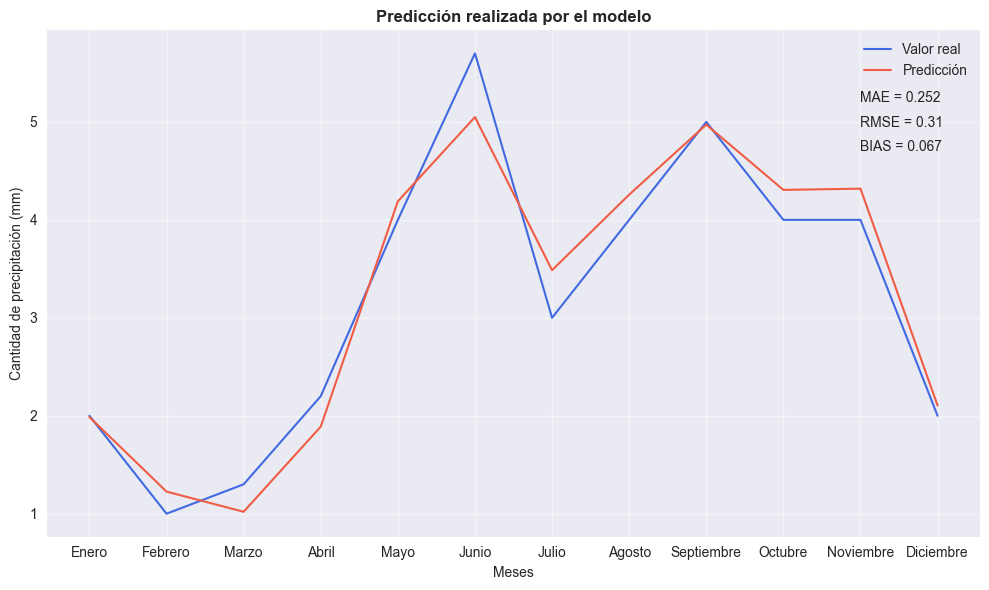

In [51]:
resultados_df = pd.DataFrame({
    'Valor real': real,
    'Predicción': predicción
})

meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(meses, resultados_df['Valor real'], color='royalblue', linewidth=1.5, label = 'Valor real')
plt.plot(meses, resultados_df['Predicción'], color = '#F05C44', linewidth=1.5, label = 'Predicción')
ax.text(10,5.2,f'MAE = {round(test_history[0],3)} ')
ax.text(10,4.95,f'RMSE = {round(test_history[1],3)} ')
ax.text(10,4.70,f'BIAS = {round(bias,3)} ')
# Personalización
plt.title('Predicción realizada por el modelo', fontsize=12)
plt.xlabel('Meses', fontsize = 10 )
plt.ylabel('Cantidad de precipitación (mm)', fontsize = 10 )
plt.grid(linewidth=1, alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()